In [1]:
#!/usr/bin/env python
# coding: utf-8
# 모델의 reproducibility를 위해 random seed를 고정함
seed_value = 743
print("Train with random seed", seed_value)

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
# tf.set_random_seed(seed_value)
# 1.--------------------------
tf.random.set_seed(seed_value)
from tensorflow.keras import backend as K
# ---------------------------

Train with random seed 743


In [2]:
import warnings
warnings.filterwarnings('ignore')

# 그래프를 그리기 위한 matplotlib 및 기타 utility 라이브러리를 import함
import pickle
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
# matplotlib를 사용해 그래프를 그릴 때 사용할 글꼴을 설정함
font_dirs = ['.']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화에 사용할 MinMaxScaler import
from sklearn.metrics import mean_squared_error  # MSE 성능 지표를 계산하기 하기 위한 함수 import

# 모델을 구축하기 위한 keras 관련 함수 import
from tensorflow.keras.models import *
from tensorflow.keras.layers import Lambda, RepeatVector
from tensorflow.keras.layers import Input, multiply
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import regularizers

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE 성능 지표를 계산하기 위한 함수 정의"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
# Define the function to return the SMAPE value
def calculate_smape(actual, predicted) -> float:
    """SMAPE 성능 지표를 계산하기 위한 함수 정의"""
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [6]:
# 클러스터링을 진행한 CSV 데이터 파일의 path를 설정함
data_filename = '../data/PM10_clustering_1day_result_1014.csv'
detrended_df = pd.read_csv(data_filename)  # Pandas의 read_csv 함수를 이용해 CSV 파일을 읽음

In [7]:
detrended_df.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Cluster
0,21.5,22.3,21.8,21.5,21.5,21.1,20.3,21.777778,22.4,21.9,...,41.2,33.8,41.4,41.3,40.0,39.2,45.4,44.3,43.1,Cluster -1
1,11.4,11.3,11.3,11.5,11.1,11.8,12.0,12.200000,12.4,13.1,...,12.5,12.6,12.8,12.9,13.4,13.4,13.1,13.3,14.8,Cluster 1
2,15.3,15.2,16.1,14.5,16.9,15.3,15.5,15.500000,15.9,16.8,...,38.0,40.3,40.6,41.5,41.7,41.1,40.5,41.3,42.2,Cluster -1
3,16.2,16.2,16.6,16.7,16.9,16.6,16.8,17.100000,17.3,17.3,...,17.1,17.7,16.2,16.4,16.7,16.9,17.0,16.3,15.8,Cluster 0
4,43.3,43.5,42.5,41.9,42.2,41.8,42.8,42.800000,42.9,43.0,...,24.1,23.6,23.7,23.9,23.5,23.7,23.0,22.0,22.0,Cluster 0


In [8]:
detrended_df['Cluster'].value_counts()  # 각 클러스터에 포함된 시계열 데이터의 샘플 수 확인

Cluster -1    65
Cluster 0     64
Cluster 1     23
Name: Cluster, dtype: int64

In [9]:
specific_df = detrended_df  # 모든 클러스터의 데이터를 사용해 훈련함

In [10]:
cluster_row_num = len(specific_df)  # 클러스터의 시계열 데이터의 샘플 수 계산

In [11]:
def get_split_row_index(total_row, train_split=0.6):
    """DataFrame을 train, test, validation으로 나누기 위한 helper 함수"""
    train_data_up = int(total_row * train_split)
    remain_data_row = cluster_row_num - train_data_up
    
    # test set과 validation set의 row 수가 같도록
    # train, test, valid split을 진행함
    if remain_data_row % 2 == 1:
        train_data_up += 1
        remain_data_row -= 1
    
    valid_data_up = int(remain_data_row / 2)
    
    assert train_data_up + valid_data_up * 2 == total_row
    
    return train_data_up, train_data_up + valid_data_up

In [12]:
specific_df.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Cluster
0,21.5,22.3,21.8,21.5,21.5,21.1,20.3,21.777778,22.4,21.9,...,41.2,33.8,41.4,41.3,40.0,39.2,45.4,44.3,43.1,Cluster -1
1,11.4,11.3,11.3,11.5,11.1,11.8,12.0,12.200000,12.4,13.1,...,12.5,12.6,12.8,12.9,13.4,13.4,13.1,13.3,14.8,Cluster 1
2,15.3,15.2,16.1,14.5,16.9,15.3,15.5,15.500000,15.9,16.8,...,38.0,40.3,40.6,41.5,41.7,41.1,40.5,41.3,42.2,Cluster -1
3,16.2,16.2,16.6,16.7,16.9,16.6,16.8,17.100000,17.3,17.3,...,17.1,17.7,16.2,16.4,16.7,16.9,17.0,16.3,15.8,Cluster 0
4,43.3,43.5,42.5,41.9,42.2,41.8,42.8,42.800000,42.9,43.0,...,24.1,23.6,23.7,23.9,23.5,23.7,23.0,22.0,22.0,Cluster 0


In [13]:
# 특정 index id를 가진 시계열 데이터 샘플을 validation set으로 사용함
valid_indexes = [91, 98, 112, 114, 116]
valid_df = specific_df[specific_df.index.isin(valid_indexes)]

In [14]:
# 특정 index id를 가진 시계열 데이터 샘플을 test set으로 사용함
test_indexes = [119, 125, 126, 138, 142]
test_df = specific_df[specific_df.index.isin(test_indexes)]

In [15]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Cluster
119,9.1,9.2,8.9,9.2,9.0,8.9,8.9,9.000000,9.1,8.7,...,21.300000,21.3,20.9,21.0,21.0,20.6,19.7,19.3,18.9,Cluster 1
125,4.0,3.8,3.8,3.8,3.8,4.0,4.0,4.111111,4.1,4.1,...,19.777778,21.0,20.9,21.2,21.6,21.8,22.0,21.7,21.1,Cluster 1
126,17.1,20.5,18.2,16.5,15.1,14.3,12.6,12.600000,11.6,11.4,...,56.400000,44.1,35.7,29.8,27.2,23.4,20.4,18.1,16.3,Cluster 1
138,4.0,3.9,3.8,3.6,3.3,3.0,2.5,2.000000,2.0,2.0,...,8.400000,8.5,9.1,9.3,9.8,9.5,9.8,10.2,10.4,Cluster 1
142,3.0,3.2,3.4,3.4,3.6,3.1,3.3,3.800000,4.0,4.1,...,10.400000,9.4,8.9,9.1,8.7,8.1,8.6,7.9,7.5,Cluster 1


In [16]:
# validation set과 test set을 제외한 나머지 모든 클러스터의 데이터 샘플을 훈련 데이터 셋으로 사용함
train_df = specific_df[~specific_df.index.isin(valid_indexes + test_indexes)]

In [17]:
# 각 DataFrame에 포함된 0 값의 갯 수를 확인함
print("Train DataFrame row: ", len(train_df))
print("Valid DataFrame row: ", len(valid_df))
print("Test DataFrame row: ", len(test_df))

Train DataFrame row:  142
Valid DataFrame row:  5
Test DataFrame row:  5


In [18]:
assert len(train_df) + len(valid_df) + len(test_df) == cluster_row_num

In [19]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Cluster
0,21.5,22.3,21.8,21.5,21.5,21.1,20.3,21.777778,22.4,21.9,...,41.2,33.8,41.4,41.3,40.0,39.2,45.4,44.3,43.1,Cluster -1
1,11.4,11.3,11.3,11.5,11.1,11.8,12.0,12.200000,12.4,13.1,...,12.5,12.6,12.8,12.9,13.4,13.4,13.1,13.3,14.8,Cluster 1
2,15.3,15.2,16.1,14.5,16.9,15.3,15.5,15.500000,15.9,16.8,...,38.0,40.3,40.6,41.5,41.7,41.1,40.5,41.3,42.2,Cluster -1
3,16.2,16.2,16.6,16.7,16.9,16.6,16.8,17.100000,17.3,17.3,...,17.1,17.7,16.2,16.4,16.7,16.9,17.0,16.3,15.8,Cluster 0
4,43.3,43.5,42.5,41.9,42.2,41.8,42.8,42.800000,42.9,43.0,...,24.1,23.6,23.7,23.9,23.5,23.7,23.0,22.0,22.0,Cluster 0


In [20]:
# DataFrame에서 `Cluster` column을 삭제함
train_df = train_df.drop(['Cluster'], axis=1).reset_index(drop=True)
valid_df = valid_df.drop(['Cluster'], axis=1).reset_index(drop=True)
test_df = test_df.drop(['Cluster'], axis=1).reset_index(drop=True)

In [21]:
# 각 DataFrame에 포함된 0 값의 갯 수를 확인함
print("Train Data - Number of 0: ", (train_df == 0).sum().sum())
print("Valid Data - Number of 0: ", (valid_df == 0).sum().sum())
print("Test Data - Number of 0: ", (test_df == 0).sum().sum())

Train Data - Number of 0:  135
Valid Data - Number of 0:  0
Test Data - Number of 0:  0


In [22]:
def dataframe_to_list(data_df):
    """DataFrame을 list로 변환하기 위한 helper 함수 정의"""
    total_data = []  # 전체 데이터 샘플 리스트
    data_list = []  # 데이터 샘플의 리스트
    for i in range(len(data_df)):
        i_row = data_df.loc[i, :].tolist()
        total_data.extend(i_row)
        data_list.append(i_row)
    
    return total_data, data_list

In [23]:
# DataFrame을 list 형태로 변환함
train_data_total, train_data_clusters = dataframe_to_list(train_df)
valid_data_total, valid_data_clusters = dataframe_to_list(valid_df)
test_data_total, test_data_clusters = dataframe_to_list(test_df)

In [24]:
def scale_data_clusters(scaler, data_clusters):
    """Scaler를 사용해 각 시계열 데이터 샘플에 대해 정규화를 진행하는 함수를 정의"""
    std_data_clusters = []
    for data_cluster in data_clusters:
        # scaler의 transform 함수를 사용해 정규화를 진행함
        std_data_cluster = scaler.transform(np.array(data_cluster).reshape(-1, 1))
        std_data_cluster = std_data_cluster.reshape(-1).tolist()
        std_data_clusters.append(std_data_cluster)
    return std_data_clusters

In [25]:
scaler = MinMaxScaler()  # MinMaxScaler 정규화 객체 생성
scaler.fit(np.array(train_data_total).reshape(-1, 1))
# 각 데이터 클러스터에 대해 정규화를 진행함
std_train_data_clusters = scale_data_clusters(scaler, train_data_clusters)
std_valid_data_clusters = scale_data_clusters(scaler, valid_data_clusters)
std_test_data_clusters = scale_data_clusters(scaler, test_data_clusters)

In [26]:
print(len(std_train_data_clusters))

142


In [27]:
def wrap_cluster(data_cluster, window_size=6, look_ahead=6):
    """List 형식의 data_cluster를 사용해 모델 입력을 위한
    (batch_size, window_size, 1) 형식으로 변환함"""
    data_x, data_y = [], []
    assert isinstance(data_cluster, list)
    data_cluster = np.array(data_cluster)
    for i in range(len(data_cluster) - window_size - look_ahead):
        x = data_cluster[i: (i + window_size)]
        y = data_cluster[i + window_size + look_ahead]
        data_x.append(x)  # window_size 만큼의 데이터를 입력으로 사용
        data_y.append(y)  # look_ahead 이후의 데이터를 예측함
    return np.array(data_x).reshape(-1, window_size, 1), np.array(data_y)

In [28]:
sample_cluster = std_train_data_clusters[0][:15]
print(sample_cluster)

[0.037896592246644926, 0.03930669800465962, 0.03842538190590044, 0.037896592246644926, 0.037896592246644926, 0.03719153936763758, 0.03578143360962289, 0.0383862123054281, 0.03948296122441146, 0.03860164512565227, 0.037015276147885745, 0.047062279673740444, 0.04406580493795922, 0.03895417156515595, 0.044947121036718406]


In [29]:
wrap_cluster(sample_cluster)

(array([[[0.03789659],
         [0.0393067 ],
         [0.03842538],
         [0.03789659],
         [0.03789659],
         [0.03719154]],
 
        [[0.0393067 ],
         [0.03842538],
         [0.03789659],
         [0.03789659],
         [0.03719154],
         [0.03578143]],
 
        [[0.03842538],
         [0.03789659],
         [0.03789659],
         [0.03719154],
         [0.03578143],
         [0.03838621]]]),
 array([0.0440658 , 0.03895417, 0.04494712]))

In [30]:
def create_dataset(data_clusters):
    """wrap_cluster 함수를 이용해 dataset 생성"""
    X, y = [], []
    for data_cluster in data_clusters:
        cluster_X, cluster_y = wrap_cluster(data_cluster)
        X.append(cluster_X)
        y.append(cluster_y)
        
    # np.concatenate 함수를 이용해 여러 게의 numpy array를 하나로 concat 함
    # [(1, window_size, 1), (1, window_size, 1)] -> (2, window_size, 1)
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

In [31]:
# train, test, validation 데이터 각각에 대해
# create_dataset 함수를 사용해 데이터 셋을 생성함
train_X, train_y = create_dataset(std_train_data_clusters)
valid_X, valid_y = create_dataset(std_valid_data_clusters)
test_X, test_y = create_dataset(std_test_data_clusters)

In [32]:
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

(18744, 6, 1) (18744,)
(660, 6, 1) (660,)
(660, 6, 1) (660,)


In [33]:
def lstm_model(batch_size, time_step, feature_num):
    """LSTM 모델 정의"""
    inputs = Input(shape=(time_step, feature_num))
    x = LSTM(6, activation='tanh',
             stateful=False,
             return_sequences=True,
             kernel_initializer='he_normal')(inputs)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(10, activation='linear', kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.))(x)
    output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)

    model = Model(inputs=[inputs], outputs=output)
    return model

In [34]:
# 하이퍼 파라미터 정의
batch_size = 4
look_back = 6
feature_num = 1

# LSTM 모델을 생성하고 compile를 진행함
model = lstm_model(batch_size, look_back, feature_num)
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
# 모델 훈련 진행
# 훈련 과정의 손실값을 history 변수에 저장
history = model.fit(train_X, train_y,
                    validation_data=(valid_X, valid_y),
                    batch_size=batch_size, epochs=10)

Epoch 1/10
4686/4686 [==============================] - 7s 1ms/step - loss: 0.0048 - val_loss: 5.6542e-04
Epoch 2/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.8737e-04 - val_loss: 5.6764e-04
Epoch 3/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.7378e-04 - val_loss: 5.8957e-04
Epoch 4/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.6698e-04 - val_loss: 5.4022e-04
Epoch 5/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.4010e-04 - val_loss: 4.8252e-04
Epoch 6/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.3486e-04 - val_loss: 5.4887e-04
Epoch 7/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.3317e-04 - val_loss: 5.8192e-04
Epoch 8/10
4686/4686 [==============================] - 6s 1ms/step - loss: 6.0801e-04 - val_loss: 5.0134e-04
Epoch 9/10
4686/4686 [==============================] - 6s 1ms/step - loss: 5.9902e-04 - val_loss: 4.9393e-04
Epoch 10/10
46

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

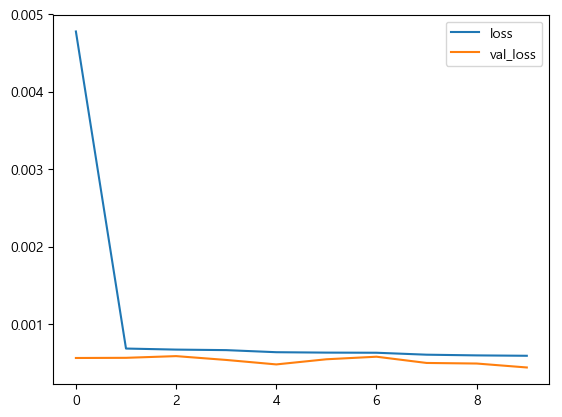

In [37]:
# train loss와 validation loss의 변화를 matplotlib를 사용해 시각화함
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()

In [38]:
# 훈련한 모델을 사용해 예측을 진행함
train_predict = model.predict(train_X, batch_size)
valid_predict = model.predict(valid_X, batch_size)
test_predict = model.predict(test_X, batch_size)

In [39]:
# 성능 측정을 위해 예측한 값에 대해 inverse transform을 진행함
inv_train_y = scaler.inverse_transform(train_y.reshape(-1, 1))
inv_train_predict = scaler.inverse_transform(train_predict)

In [40]:
inv_valid_y = scaler.inverse_transform(valid_y.reshape(-1, 1))
inv_valid_predict = scaler.inverse_transform(valid_predict)

In [41]:
inv_test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
inv_test_predict = scaler.inverse_transform(test_predict)

In [42]:
# train, test, validation set에 대해 MAPE 계산
train_mape = mean_absolute_percentage_error(inv_train_y, inv_train_predict)
valid_mape = mean_absolute_percentage_error(inv_valid_y, inv_valid_predict)
test_mape = mean_absolute_percentage_error(inv_test_y, inv_test_predict)

In [43]:
print("Train MAPE: %.2f" % train_mape)
print("Valid MAPE: %.2f" % valid_mape)
print("Test MAPE: %.2f" % test_mape)

Train MAPE: inf
Valid MAPE: 26.58
Test MAPE: 39.06


In [44]:
# train, test, validation set에 대해 SMAPE 계산
train_smape = calculate_smape(inv_train_y, inv_train_predict)
valid_smape = calculate_smape(inv_valid_y, inv_valid_predict)
test_smape = calculate_smape(inv_test_y, inv_test_predict)

In [45]:
print("Train SMAPE: %.2f" % train_smape)
print("Valid SMAPE: %.2f" % valid_smape)
print("Test SMAPE: %.2f" % test_smape)

Train SMAPE: 30.30
Valid SMAPE: 25.98
Test SMAPE: 32.14


In [46]:
# train, test, validation set에 대해 MSE 계산
train_mse = mean_squared_error(inv_train_y, inv_train_predict)
valid_mse = mean_squared_error(inv_valid_y, inv_valid_predict)
test_mse = mean_squared_error(inv_test_y, inv_test_predict)

In [47]:
print("Train MSE: %.2f" % train_mse)
print("Valid MSE: %.2f" % valid_mse)
print("Test MSE: %.2f" % test_mse)

Train MSE: 155.67
Valid MSE: 130.31
Test MSE: 52.19


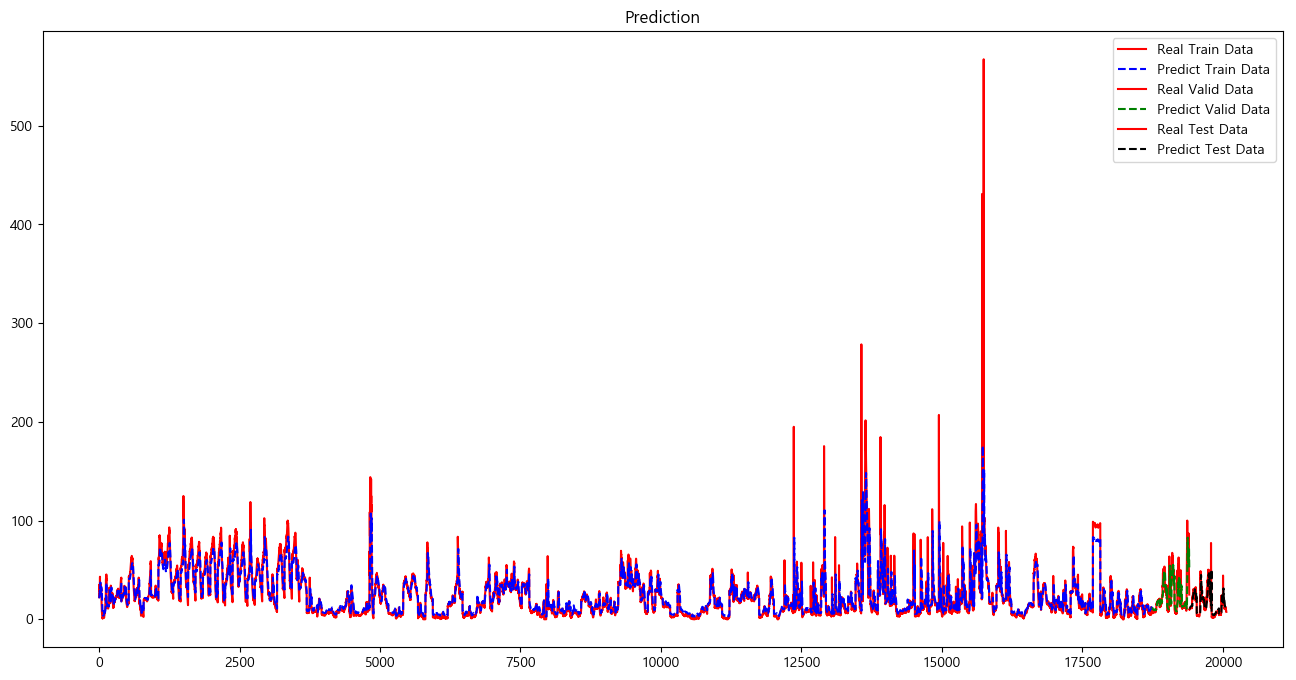

In [48]:
# matplotlib을 이용해 train, test, validation set에 대한 실제값과 예측값을 시각화함
train_term = len(inv_train_y)
valid_term = len(inv_train_y) + len(inv_valid_y)
total_sample = len(inv_train_y) + len(inv_valid_y) + len(inv_test_y)

plt.figure(figsize=(16, 8))
plt.plot(np.arange(train_term), inv_train_y, color='red', ls='-', label='Real Train Data')
plt.plot(np.arange(train_term), inv_train_predict, color='blue', ls='--', label='Predict Train Data')
plt.plot(np.arange(train_term, valid_term), inv_valid_y, color='red', ls='-', label='Real Valid Data')
plt.plot(np.arange(train_term, valid_term), inv_valid_predict, color='green', ls='--', label='Predict Valid Data')
plt.plot(np.arange(valid_term, total_sample), inv_test_y, color='red', ls='-', label='Real Test Data')
plt.plot(np.arange(valid_term, total_sample), inv_test_predict, color='black', ls='--', label='Predict Test Data')
plt.title('Prediction')
plt.legend()

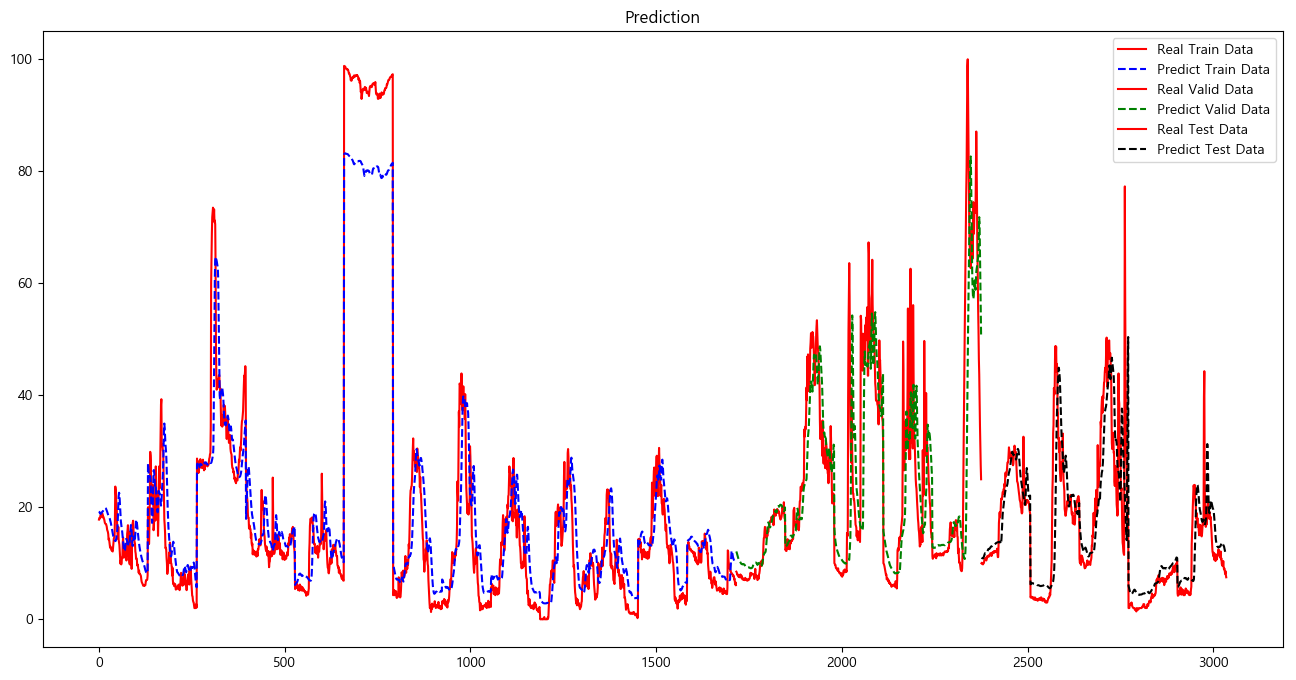

In [49]:
# matplotlib을 이용해 train set의 마지막 부분과 test, validation set에 대한 실제값과 예측값을 시각화함
train_term = 1716
valid_term = train_term + len(inv_valid_y)
total_sample = train_term + len(inv_valid_y) + len(inv_test_y)

plt.figure(figsize=(16, 8))
plt.plot(np.arange(train_term), inv_train_y[-train_term:], color='red', ls='-', label='Real Train Data')
plt.plot(np.arange(train_term), inv_train_predict[-train_term:], color='blue', ls='--', label='Predict Train Data')
plt.plot(np.arange(train_term, valid_term), inv_valid_y, color='red', ls='-', label='Real Valid Data')
plt.plot(np.arange(train_term, valid_term), inv_valid_predict, color='green', ls='--', label='Predict Valid Data')
plt.plot(np.arange(valid_term, total_sample), inv_test_y, color='red', ls='-', label='Real Test Data')
plt.plot(np.arange(valid_term, total_sample), inv_test_predict, color='black', ls='--', label='Predict Test Data')
plt.title('Prediction')
plt.legend()